In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType

In [0]:
DATA_PATH = "/Volumes/flight/default/final_single_csv/flight_with_weather_2019/flight_with_weather_2019.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(DATA_PATH)


In [0]:
df.printSchema()
df.select(
    "DEP_DELAY", "ARR_DELAY",
    "TAXI_OUT", "TAXI_IN",
    "AIR_TIME", "CRS_ELAPSED_TIME"
).summary().show()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: timestamp (nullable = true)
 |-- DEP_TIME: timestamp (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: timestamp (nullable = true)
 |-- WHEELS_ON: timestamp (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: timestamp (nullable = true)
 |-- ARR_TIME: timestamp (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- FLIGHTS: double (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- ORIGIN_INDEX: integer (nullable = true)
 |-- DE

In [0]:
required_cols = [
    "DEP_DELAY", "ARR_DELAY",
    "TAXI_OUT", "TAXI_IN",
    "AIR_TIME", "CRS_ELAPSED_TIME"
]

df_clean = df.dropna(subset=required_cols)

In [0]:
delay_cols = ["DEP_DELAY", "ARR_DELAY", "TAXI_OUT", "TAXI_IN"]

for col in delay_cols:
    df_clean = df_clean.withColumn(
        col,
        F.when(F.col(col) < 0, 0).otherwise(F.col(col))
    )

In [0]:
df_clean = df_clean.withColumn(
    "SCHEDULED_AIR_TIME",
    F.col("CRS_ELAPSED_TIME") - F.lit(25)
)

In [0]:
df_clean = df_clean.withColumn(
    "AIR_DELAY",
    F.col("AIR_TIME") - F.col("SCHEDULED_AIR_TIME")
)

df_clean = df_clean.withColumn(
    "AIR_DELAY",
    F.when(F.col("AIR_DELAY") < 0, 0).otherwise(F.col("AIR_DELAY"))
)

In [0]:
df_clean = df_clean.withColumn(
    "GROUND_DELAY",
    F.col("DEP_DELAY") + F.col("TAXI_OUT")
)

In [0]:
df_clean = df_clean.withColumn(
    "ARRIVAL_CONGESTION_DELAY",
    F.col("TAXI_IN")
)

In [0]:
df_clean = df_clean.withColumn(
    "WEATHER_DELAY",
    F.when(
        (F.col("O_PRCP") > 0) | (F.col("O_WSPD") > 20),
        F.col("ARR_DELAY")
    ).otherwise(0)
)

In [0]:
df_clean.select(
    "ARR_DELAY",
    "GROUND_DELAY",
    "AIR_DELAY",
    "ARRIVAL_CONGESTION_DELAY",
    "WEATHER_DELAY"
).show(5)

+---------+------------+---------+------------------------+-------------+
|ARR_DELAY|GROUND_DELAY|AIR_DELAY|ARRIVAL_CONGESTION_DELAY|WEATHER_DELAY|
+---------+------------+---------+------------------------+-------------+
|      0.0|        11.0|      0.0|                     5.0|          0.0|
|      0.0|        15.0|      0.0|                     2.0|          0.0|
|      0.0|        16.0|      0.0|                    10.0|          0.0|
|      0.0|        10.0|      0.0|                    14.0|          0.0|
|      0.0|        25.0|      0.0|                     9.0|          0.0|
+---------+------------+---------+------------------------+-------------+
only showing top 5 rows


In [0]:
delay_summary = df_clean.select(
    F.avg("GROUND_DELAY").alias("Ground"),
    F.avg("AIR_DELAY").alias("Air"),
    F.avg("ARRIVAL_CONGESTION_DELAY").alias("Arrival"),
    F.avg("WEATHER_DELAY").alias("Weather")
)

delay_summary.show()

+------------------+----------------+------------------+-----------------+
|            Ground|             Air|           Arrival|          Weather|
+------------------+----------------+------------------+-----------------+
|31.423995552267147|1.73056079029096|7.7473713435175355|4.655753465329665|
+------------------+----------------+------------------+-----------------+



In [0]:
pdf = delay_summary.toPandas()

In [0]:
delay_summary = df_clean.select(
    F.avg("GROUND_DELAY").alias("Ground"),
    F.avg("AIR_DELAY").alias("Air"),
    F.avg("ARRIVAL_CONGESTION_DELAY").alias("Arrival"),
    F.avg("WEATHER_DELAY").alias("Weather")
)

pdf1 = delay_summary.toPandas()

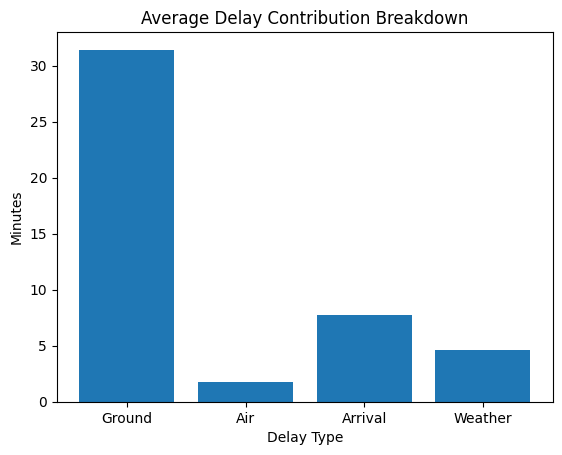

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(pdf1.columns, pdf1.iloc[0].values)
plt.title("Average Delay Contribution Breakdown")
plt.ylabel("Minutes")
plt.xlabel("Delay Type")
plt.show()

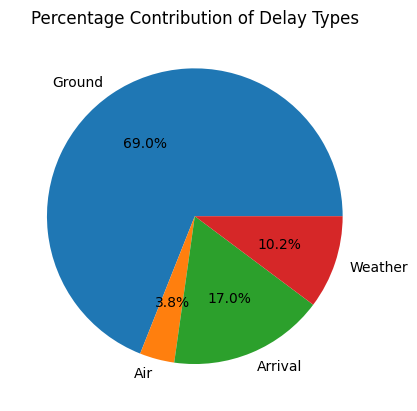

In [0]:
values = pdf1.iloc[0].values
labels = pdf1.columns

plt.figure()
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Percentage Contribution of Delay Types")
plt.show()

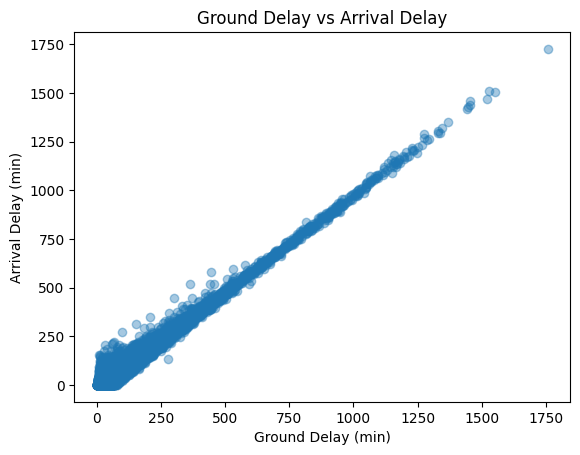

In [0]:
pdf3 = df_clean.select(
    "GROUND_DELAY", "ARR_DELAY"
).sample(0.05).toPandas()
plt.figure()
plt.scatter(pdf3["GROUND_DELAY"], pdf3["ARR_DELAY"], alpha=0.4)
plt.xlabel("Ground Delay (min)")
plt.ylabel("Arrival Delay (min)")
plt.title("Ground Delay vs Arrival Delay")
plt.show()

In [0]:
weather_compare = df_clean.withColumn(
    "WEATHER_FLAG",
    F.when(F.col("WEATHER_DELAY") > 0, "Weather").otherwise("No Weather")
).groupBy("WEATHER_FLAG").agg(
    F.avg("ARR_DELAY").alias("AVG_ARR_DELAY")
)

pdf4 = weather_compare.toPandas()

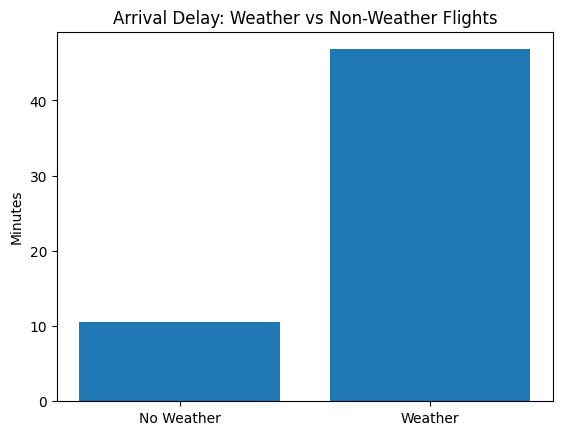

In [0]:
plt.figure()
plt.bar(pdf4["WEATHER_FLAG"], pdf4["AVG_ARR_DELAY"])
plt.title("Arrival Delay: Weather vs Non-Weather Flights")
plt.ylabel("Minutes")
plt.show()

In [0]:
monthly_delay = df_clean.withColumn(
    "MONTH", F.month("FL_DATE")
).groupBy("MONTH").agg(
    F.avg("ARR_DELAY").alias("AVG_ARR_DELAY")
).orderBy("MONTH")

pdf5 = monthly_delay.toPandas()

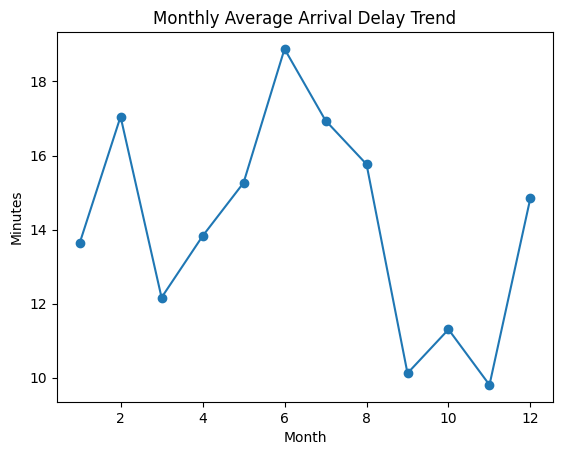

In [0]:
plt.figure()
plt.plot(pdf5["MONTH"], pdf5["AVG_ARR_DELAY"], marker='o')
plt.title("Monthly Average Arrival Delay Trend")
plt.xlabel("Month")
plt.ylabel("Minutes")
plt.show()

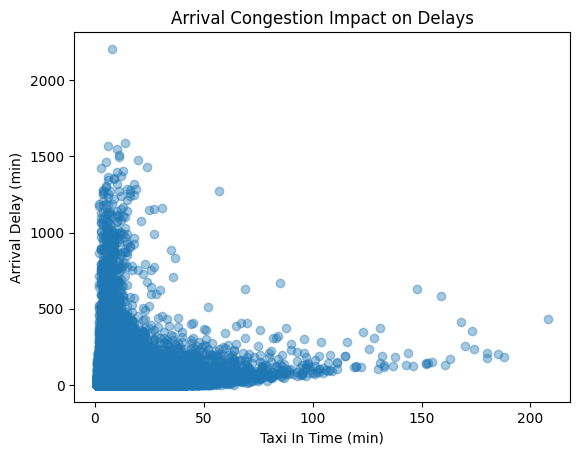

In [0]:
pdf6 = df_clean.select(
    "TAXI_IN", "ARR_DELAY"
).sample(0.05).toPandas()
plt.figure()
plt.scatter(pdf6["TAXI_IN"], pdf6["ARR_DELAY"], alpha=0.4)
plt.xlabel("Taxi In Time (min)")
plt.ylabel("Arrival Delay (min)")
plt.title("Arrival Congestion Impact on Delays")
plt.show()

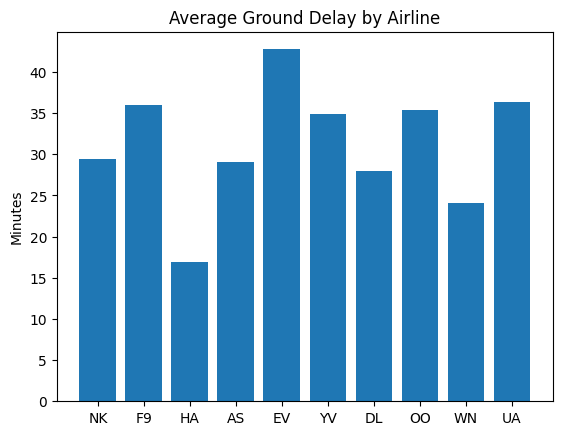

In [0]:
airline_delay = df_clean.groupBy("OP_CARRIER").agg(
    F.avg("GROUND_DELAY").alias("Ground"),
    F.avg("AIR_DELAY").alias("Air"),
    F.avg("ARRIVAL_CONGESTION_DELAY").alias("Arrival")
)

pdf7 = airline_delay.limit(10).toPandas()
plt.figure()
plt.bar(pdf7["OP_CARRIER"], pdf7["Ground"])
plt.title("Average Ground Delay by Airline")
plt.ylabel("Minutes")
plt.show()